In [2]:
# Install imageio for creating animations.
!pip -q install imageio
!pip -q install scikit-image
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-f43010jd
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-f43010jd
  Resolved https://github.com/tensorflow/docs to commit 5d59abc7f34ac0de5ae18bb49d3b0d65649e1892
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=151748 sha256=215787d02faf76d544f21fbdb5d8b1dc4c35805b516c4f33358e5eb8167d2809
  Stored in directory: /tmp/pip-ephem-wheel-cache-w768nm9z/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [5]:
!pip install --upgrade tensorflow-hub

     |████████████████████████████████| 108 kB 28.9 MB/s eta 0:00:01


# ⚙️ Import 

In [6]:
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
    from google.colab import files
except ImportError:
    pass

from IPython import display
from skimage import transform

In [11]:
# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512

logging.set_verbosity(logging.ERROR)

# 📙 Define function

In [7]:

# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)

    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

In [8]:
# Simple way to display an image.
def display_image(image):
    image = tf.constant(image)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return PIL.Image.fromarray(image.numpy())

In [9]:
# Given a set of images, show an animation.
def animate(images):
    images = np.array(images)
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)
    return embed.embed_file('./animation.gif')

In [10]:
logging.set_verbosity(logging.ERROR)

# Latent Space Interpolation

https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d

### Latent 

데이터를 압축하는 방식. 이 과정에서 '숨겨진', '잠재의' latent 단어를 사용하게 된 것.

데이터 압축은 원래 표현보다 적은 비트를 사용하여 정보를 encoding하는 과정. 이미지 분류 모델이 학습이 진행될 수록 이미지 차원이 기하 급수적으로 증가한다. 그래서 이전에 감소시키는 과정을 넣음. 

여기서 압축된 데이터를 재구성하는 모델이 필요한데 decoder역할을 하게 된다. 그럼 noise를 무시하는 방법을 학습하여 불필요한 정보를 제거할 수 있다는 장점이 있다



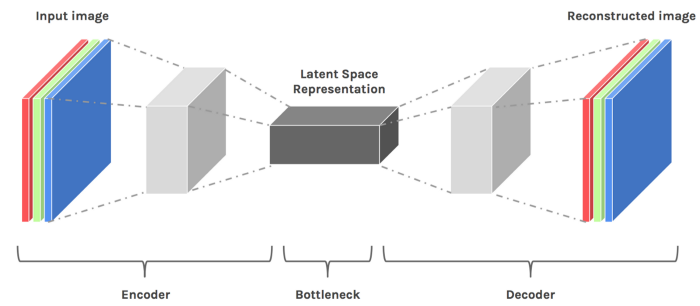

### Space

t-SNE와 같은 도구를 통해 2,3 차원 너머의 공간을 시각화할 수 있다.

공간에서의 유사성은 무엇을 의미할까? 아래 이미지에서 2개의 의자는 서로 비슷하고 책상은 두 이미지와 다르다고 이야기할 수 있다. 그런데 의자끼리 비교한다면 다리 사이 연결, 모서리, 각도 등의 패턴을 학습해야만 모델이 모두 이해할 수 있다. 이러한 특징들은 데이터의 잠재 공간에 표현된다.

따라서 차원이 감소할 수록 각 이미지의 중요한 특징만 잠재 공간에 저장되기에 색상같은 정보들은 제거될 수 있다. 결과적으로 차원을 줄이면 두 의자의 표현이 덜 구별되고 유사해지며 공간 상에서 '더 가까이' 있게 된다. ( 공간 상 거리에는 여러 정의가 있기 때문에 유클리디안 거리로 고려하지 말기)

공간의 중요성을 본다면 아래 두 그래프를 비교해보자. 3D의 결과와 2D의 결과에서 다른 것을 같은 것으로 인식할 수 있게 된다는 점을 느낄 수 있을 것이다.

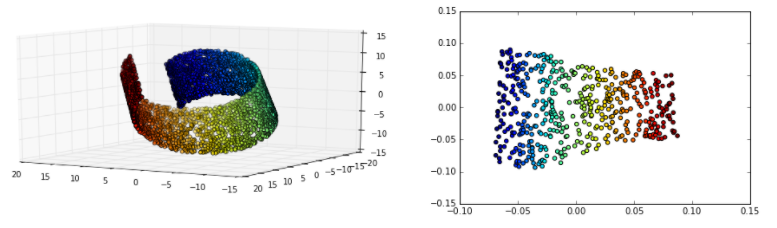

잠재 공간에서 데이터의 '근접성'은 일반적으로 Auto Encoder를 통해 조절한다. 우리는 모델이 무엇을 출력하는지가 아닌 모델이 그 과정에서 무엇을 배우는지에 더 관심이 있기 때문에 이 과정이 필요.

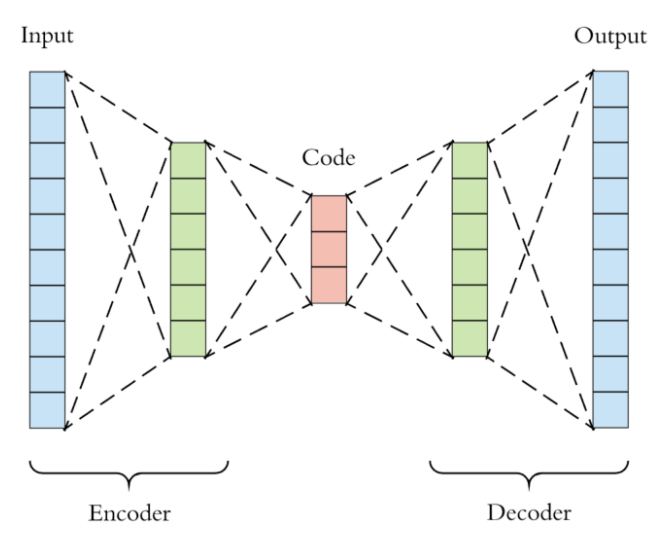
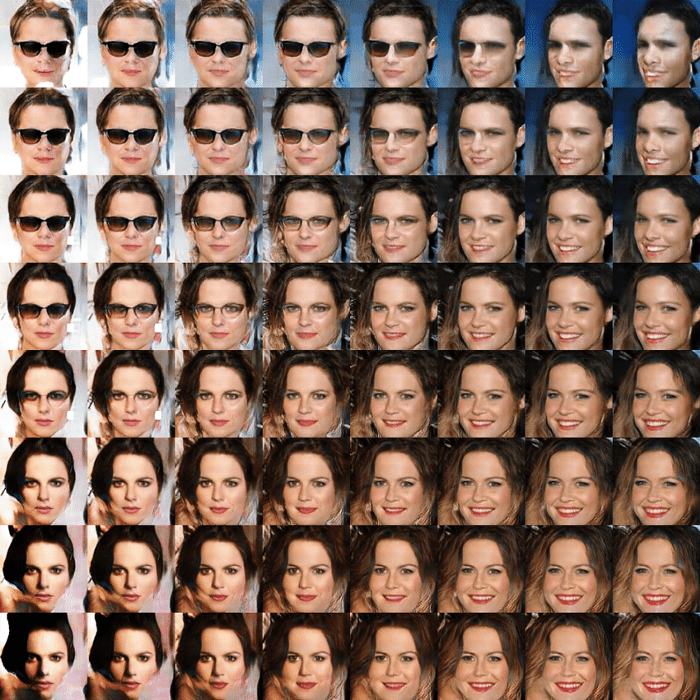

### Interpolation
압축한 이미지를 decoder에 보냈을 때 두 의자의 중간 지점의 새로운 이미지를 얻을 수 있다. 아래 예시는 잠재 공간에서 두 의자 사이의 선형 보간의 예.

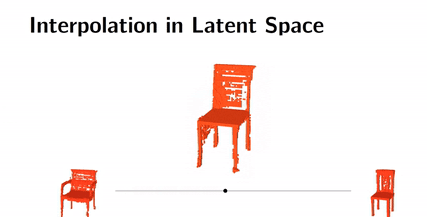

# Random Vecotrs in Latent Space Interpolation

TF Hub의 progan-128 (Progressive GAN)을 이용하려 합니다.

v1과 v2 벡터 사이에는 25 단계의 interpolation을 tensor 형태로 생성하고요

In [12]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']

2021-11-25 18:56:10.812901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 18:56:11.242086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 18:56:11.242870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 18:56:11.244537: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2021-11-25 18:56:23.070359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101



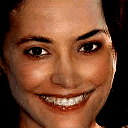

In [13]:
def interpolate_between_vectors():
    v1 = tf.random.normal([latent_dim])
    v2 = tf.random.normal([latent_dim])

      # Creates a tensor with 25 steps of interpolation between v1 and v2.
    vectors = interpolate_hypersphere(v1, v2, 50)

      # Uses module to generate images from the latent space.
    interpolated_images = progan(vectors)['default']

    return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

# Latent Space에서 가장 가까운 벡터 찾기

target image를 고정시켜서 여러분이 직접 올린 사진에 적용해보세요.

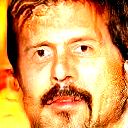

In [14]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
    vector = tf.random.normal([1, latent_dim])
    images = progan(vector)['default'][0]
    return images

def upload_image():
    uploaded = files.upload()
    image = imageio.imread(uploaded[list(uploaded.keys())[0]])
    return transform.resize(image, [128, 128])

if image_from_module_space:
    target_image = get_module_space_image()
else:
    target_image = upload_image() # image_from_module_space = False

display_image(target_image)

# Apply Loss function 

target image와 latent space variable에 의해 생성된 image 사이에 대한 loss fucntion을 정의하여 적용해봅시다. 그리고 경사하강법을 써서 loss를 최소화하는 variable 값도 찾아봅시다.

latent vector는 정규화된 분포에서 뽑은 샘플 데이터 입니다. 
이 분포 속 벡터들의 평균 길이로 지금 뽑은 벡터의 길이를 일반화시키면 좀 더 현실적인 이미지를 얻을 수 있습니대.


In [18]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
    images = []
    losses = []

    vector = tf.Variable(initial_vector)  
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

    for step in range(num_optimization_steps):
        if (step % 100)==0:
            print()
        print('.', end='')
        with tf.GradientTape() as tape:
            image = progan(vector.read_value())['default'][0]
            if (step % steps_per_image) == 0:
                images.append(image.numpy())
            target_image_difference = loss_fn(image, target_image[:,:,:3])
              # The latent vectors were sampled from a normal distribution. We can get
              # more realistic images if we regularize the length of the latent vector to 
              # the average length of vector from this distribution.
            regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

            loss = target_image_difference + regularizer
            losses.append(loss.numpy())
        grads = tape.gradient(loss, [vector])
        optimizer.apply_gradients(zip(grads, [vector]))

    return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

(0.0, 6696.229827880859)

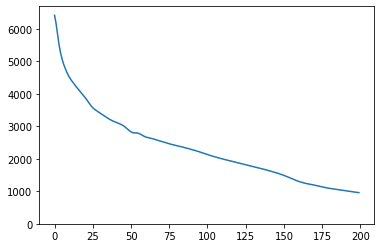

In [19]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


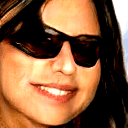

In [20]:
animate(np.stack(images))

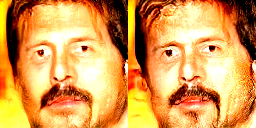

In [21]:
display_image(np.concatenate([images[-1], target_image], axis=1))

# Further 
더 빠르고 진행되고 사실적인 이미지가 나오게 하려면?
- 이미지 차이에 대해 다른 loss를 사용 (4차원으로 한다던가?)
- 잠재 벡터에 대해 다른 정규화 사용
- 수 없이 실행시키 random vector로 초기화하기
- ...